In [5]:
import numpy as np
import pandas as pd

import torch
from torch import nn
from Dataset.embedding_dataset import AutoEncoder_Dataset
from Model.AutoEncoder import AutoEncoder
from torch.utils.data import DataLoader

## embedding

### embedding matrix

In [4]:
batch = 32
epochs = 50
embedding_dim = 6

In [8]:
table_1 = pd.read_excel('../데이터/Table/table_1.xlsx', index_col=0)
table_2 = pd.read_excel('../데이터/Table/table_2.xlsx', index_col=0)
table_3 = pd.read_excel('../데이터/Table/table_3.xlsx', index_col=0)

dataset = AutoEncoder_Dataset(table_1, table_2, table_3)
dataloader = DataLoader(dataset, batch_size=batch)

NameError: name 'batch' is not defined

In [9]:
model = AutoEncoder(embedding_dim)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model.train()
train_losses = []
for epoch in range(epochs):
    total_train_loss = 0
    for data in dataloader:
        input = data[0]
        target = data[1]
        output = model(input)

        train_loss = criterion(output, target)
        total_train_loss += train_loss.item()

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

    avg_train_loss = total_train_loss / len(dataloader)
    train_losses.append(avg_train_loss)
    print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}')

torch.save(model, f'../데이터/Checkpoint/embedding_batch_{batch}_epochs_{epochs}_dim_{embedding_dim}.pth')

Epoch [1/50], Train Loss: 680291770.6692
Epoch [2/50], Train Loss: 684188173.6263
Epoch [3/50], Train Loss: 689512574.3303
Epoch [4/50], Train Loss: 692086335.6111
Epoch [5/50], Train Loss: 688067731.1787
Epoch [6/50], Train Loss: 686715738.7562
Epoch [7/50], Train Loss: 682496298.9647
Epoch [8/50], Train Loss: 679622162.8559
Epoch [9/50], Train Loss: 676958141.1462
Epoch [10/50], Train Loss: 674317575.5218
Epoch [11/50], Train Loss: 672776078.0742
Epoch [12/50], Train Loss: 671834476.7615
Epoch [13/50], Train Loss: 673883822.9061
Epoch [14/50], Train Loss: 672292985.3853
Epoch [15/50], Train Loss: 670222568.7711
Epoch [16/50], Train Loss: 668870535.0658
Epoch [17/50], Train Loss: 667554694.9468
Epoch [18/50], Train Loss: 665938823.2288
Epoch [19/50], Train Loss: 664633780.7509
Epoch [20/50], Train Loss: 663488408.7713
Epoch [21/50], Train Loss: 662454541.6991
Epoch [22/50], Train Loss: 661524744.7534
Epoch [23/50], Train Loss: 660687875.5072
Epoch [24/50], Train Loss: 659936261.2933
E

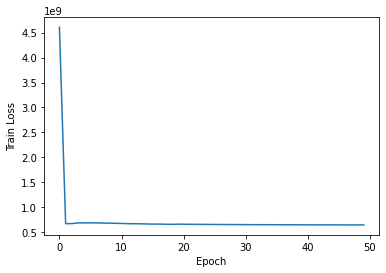

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.show()

### embedding vector

In [14]:
apartment = '경남1'

In [15]:
table_1[table_1['name'] == apartment][[cols for cols in table_1.columns if cols not in ['location','name']]]

,aid,lat,lng,year_built,education,household,parking,complex_facility,move_in_day,subway_distance,convenience_facility
0,0,37.484387,127.054267,1984,7,678,1,3,14543,8,10


In [17]:
table_3[table_3['aid']==0]

,aid,did,price
0,0,0,87000
1,0,0,85700
2,0,0,91500
3,0,0,87000
4,0,2,90000
...,...,...,...
121,0,169,197000
122,0,173,200000
123,0,174,215000
124,0,174,210000


In [9]:
apartment_tensor = torch.FloatTensor(table_1[table_1['name'] == apartment][[cols for cols in table_1.columns if cols not in ['aid','location','name']]].values)

In [10]:
apartment_tensor

tensor([[3.7508e+01, 1.2702e+02, 2.0090e+03, 4.0000e+00, 3.4100e+03, 2.0000e+00,
         0.0000e+00, 5.1270e+03, 3.0000e+00, 3.0000e+00]])

In [2]:
input_tensor = []

for year in range(2006,2023):
    for month in range(1,13):
        input_tensor.append()

TypeError: list.append() takes exactly one argument (0 given)

In [72]:
kn1

tensor([3.7484e+01, 1.2705e+02, 1.9840e+03, 7.0000e+00, 6.7800e+02, 1.0000e+00,
        3.0000e+00, 1.4543e+04, 8.0000e+00, 1.0000e+01, 3.7400e+00, 1.0277e+06])

In [78]:
model = torch.load('../../데이터/Checkpoint/embedding_batch_32_epochs_50_dim_6.pth')

model.eval()
with torch.no_grad():
    embedding_matrix = model.encoder(kn1).numpy()

In [79]:
embedding_matrix

array([ 66526.37 ,  73717.07 ,  48849.918, 159731.05 ,  35686.473,
        65232.055], dtype=float32)